# Лабораторная работа 6.

## «Моделирование и прогнозирование временных рядов»

**Задание:** имеется временной ряд производства молока (тыс.тонн) в Псковской области за 2008-2022 гг.

**Требуется:**

1. Подготовить данные в виде временного ряда.

2. Провести графический анализ временного ряда.

3. Выполнить моделирование и прогнозирование уровней временного ряда на декабрь 2022 г. -март 2023 г., используя известные методы и технологии. 

**Этапы выполнения задания:**

1. Выполнить декомпозицию задач. 

2. Загрузить файл, импортировать основные библиотеки, изучить общую информацию о временном ряде. 

3. Провести анализ временного ряда, предобработку данных.

4. Выполнить декомпозицию временного ряда в аддитивной и мультипликативной формах.

5. Построить краткострочный прогноз на основе тройного сглаживания Хольта.

6. Построить ряд, очищенный от сезонности, проверить ряд на стационарность.

7. Построить стационарный ряд, используя оператор последовательных разностей (дифференцирование ряда).

8. Построить ARIMA-модель, обосновать параметры выбора модели.

9. Провести графический анализ фактических, модельных значений, анализ остатков модели.

10. Построить прогнозы.

11. Оформить подробный отчет, все результаты должны иметь интерпретацию, выводы должны быть обоснованы. 


## 1. Выполнить декомпозицию задач.

### Содержание:

* [2. Загрузить файл, импортировать основные библиотеки, изучить общую информацию о временном ряде.](#2)

* [3. Провести анализ временного ряда, предобработку данных.](#3)

* [4. Выполнить декомпозицию временного ряда в аддитивной и мультипликативной формах.](#4)

* [5. Построить краткострочный прогноз на основе тройного сглаживания Хольта.](#5)

* [6. Построить ряд, очищенный от сезонности, проверить ряд на стационарность.](#6)

* [7. Построить стационарный ряд, используя оператор последовательных разностей (дифференцирование ряда).](#7)

* [8. Построить ARIMA-модель, обосновать параметры выбора модели.](#8)

* [9. Провести графический анализ фактических, модельных значений, анализ остатков модели.](#9)

* [10. Построить прогнозы.](#10)

## 2. Загрузить файл, импортировать основные библиотеки, изучить общую информацию о временном ряде. <a class="anchor" id="2"></a>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from math import sqrt
from datetime import timedelta

import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from arch.unitroot import PhillipsPerron

from scipy import signal

from sklearn.metrics import mean_squared_error

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_squared_error, geometric_mean_squared_error
from sktime.utils.plotting import plot_series

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка и просмотр датасета
# сразу превратим дату в индекс и преобразуем ее в datetime
df = pd.read_excel("./data/lab_6.xls", index_col='date', parse_dates=True)
df.head()

,milk
date,
2008-01-01,12.2
2008-02-01,12.7
2008-03-01,20.4
2008-04-01,23.1
2008-05-01,25.5


## 3. Провести анализ временного ряда, предобработку данных.

In [3]:
# Просмотр информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 179 entries, 2008-01-01 to 2022-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   milk    179 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB


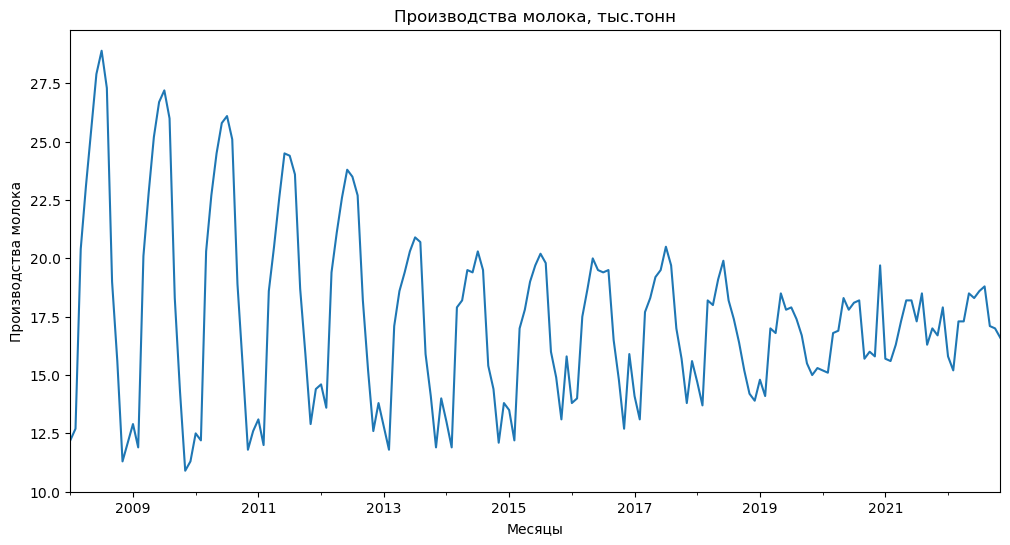

In [4]:
# Построение графика временного ряда
ax = df["milk"].plot(figsize=(12, 6), legend=None)
ax.set(title="Производства молока, тыс.тонн", xlabel="Месяцы", ylabel="Производства молока")
plt.show()

In [5]:
# Вывод описательной статистики
df.describe()

,milk
count,179.000000
mean,17.469274
std,3.818642
min,10.900000
25%,14.750000
50%,17.300000
75%,19.450000
max,28.900000


## 4. Выполнить декомпозицию временного ряда в аддитивной и мультипликативной формах.

**Коррелограмма выборочной автокорреляционной функции:**
$$\hat{\rho}(\tau) = \frac{\bar{y}_{t}\bar{y}_{t+\tau}-\bar{y}_{t}\cdot\bar{y}_{t+\tau}}{\hat{\sigma}_{y_{t}}\hat{\sigma}_{y_{t+\tau}}}$$

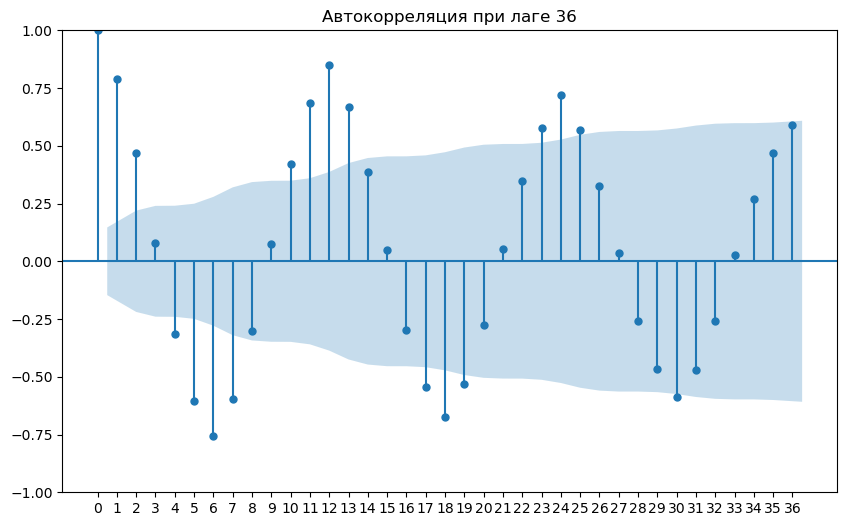

In [6]:
rcParams['figure.figsize'] = 10, 6
plot_acf(df, lags=36)
plt.xticks(ticks=range(37))
plt.title("Автокорреляция при лаге 36")
plt.show()

**Выводы:**

* Автокорреляция позволяет выявлять тренд и сезонность. Заметим, что лаг 12 сильнее коррелирует с исходным рядом, чем соседние лаги 11 и 13. То же самое можно сказать и про лаги 24 и 36. Такая автокорреляция позволяет предположить наличие ежегодных сезонных колебаний.

* Переменчивая по знаку корреляция говорит о отсутствии тренда.

* Если столбец выходит за пределы синей границы, то автокорреляция достаточно сильна.

* Вывод по структуре временного ряда: временной ряд не имеет тренд, а также сильную автокорреляцию при лаге 12, что говорит о сезонности равной 12 месяцам (ежегодной)

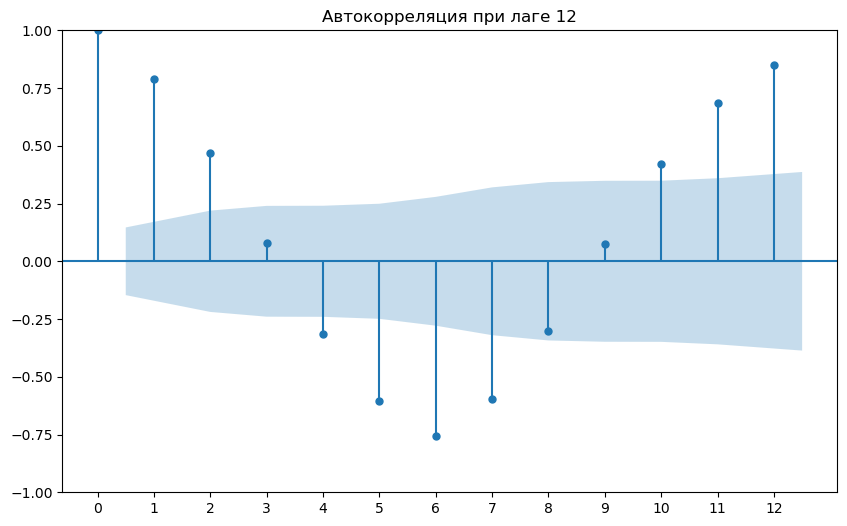

In [7]:
plot_acf(df, lags=12)
plt.xticks(ticks=range(13))
plt.title("Автокорреляция при лаге 12")
plt.show()

## 5. Построить краткострочный прогноз на основе тройного сглаживания Хольта.

**Тройное экспоненциальное сглаживание - это расширение экспоненциального сглаживания, которое добавляет сезонность в одномерный временной ряд с тенденцией.**

In [8]:
# Инициализация и прогнозирование модели экспоненциального сглаживания Холта Винтера (HWES).
model_EMA = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add').fit()
y_pred_EMA = model_EMA.forecast(6)
print(y_pred_EMA)
model_EMA.summary()

2022-12-01    18.274563
2023-01-01    16.064527
2023-02-01    15.451832
2023-03-01    17.337656
2023-04-01    17.322130
2023-05-01    18.474585
Freq: MS, dtype: float64


Dep. Variable:,milk,No. Observations:,179
Model:,ExponentialSmoothing,SSE,148.153
Optimized:,True,AIC,-1.856
Trend:,Additive,BIC,49.143
Seasonal:,Additive,AICC,2.419
Seasonal Periods:,12,Date:,"Fri, 13 Jan 2023"
Box-Cox:,False,Time:,11:06:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1644912,alpha,True
smoothing_trend,0.000000,beta,True


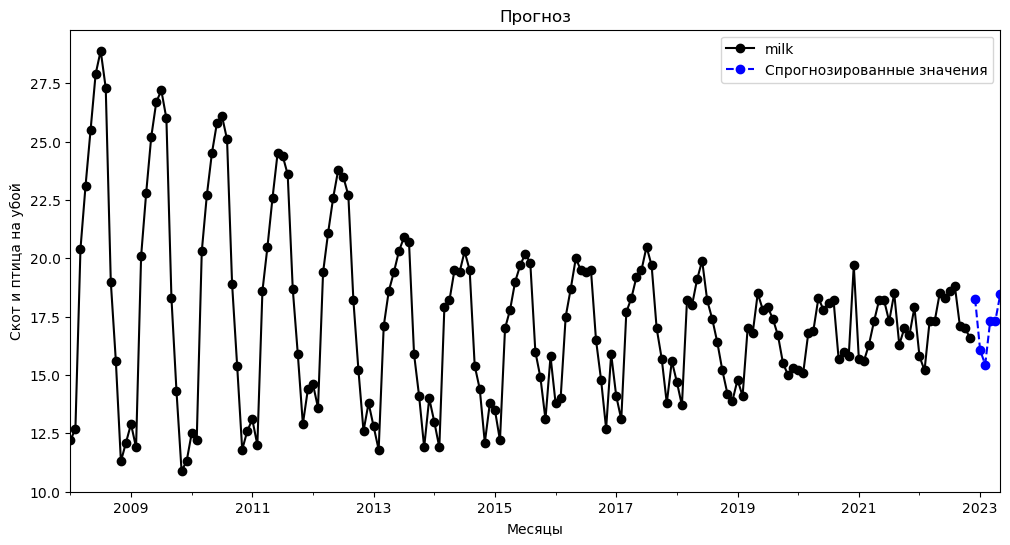

In [9]:
# Графический вывод прогноза.
ax = df.plot(figsize=(12, 6), marker='o', color='black', title="Прогноз")
ax.set_ylabel('Скот и птица на убой')
ax.set_xlabel('Месяцы')
model_EMA.forecast(6).rename('Спрогнозированные значения').plot(ax=ax, style='--', marker='o', color='blue', legend=True)
plt.show()

## 6. Построить ряд, очищенный от сезонности, проверить ряд на стационарность.

In [10]:
# Аддитивная форма
decompose_add = seasonal_decompose(df, period=12, model='additive', extrapolate_trend='freq')
df_decompose_add = pd.concat([decompose_add.observed, decompose_add.seasonal, decompose_add.trend, decompose_add.resid], axis=1)
df_decompose_add.columns = ['actual_values', 'seasonal', 'trend', 'resid']
df_decompose_add.head()

,actual_values,seasonal,trend,resid
date,,,,
2008-01-01,12.2,-3.602485,20.218439,-4.415954
2008-02-01,12.7,-4.185547,20.147693,-3.262147
2008-03-01,20.4,0.681392,20.076947,-0.358339
2008-04-01,23.1,1.787497,20.006201,1.306301
2008-05-01,25.5,3.240269,19.935456,2.324275


In [11]:
# Мультпликативная форма
decompose_mult = seasonal_decompose(df, period=12, model='multiplicative', extrapolate_trend='freq')
df_decompose_mult = pd.concat([decompose_mult.observed, decompose_mult.seasonal, decompose_mult.trend, decompose_mult.resid], axis=1)
df_decompose_mult.columns = ['actual_values', 'seasonal', 'trend', 'resid']
df_decompose_mult.head()

,actual_values,seasonal,trend,resid
date,,,,
2008-01-01,12.2,0.800047,20.218439,0.754218
2008-02-01,12.7,0.764978,20.147693,0.824004
2008-03-01,20.4,1.039308,20.076947,0.977661
2008-04-01,23.1,1.100017,20.006201,1.049658
2008-05-01,25.5,1.182265,19.935456,1.081930


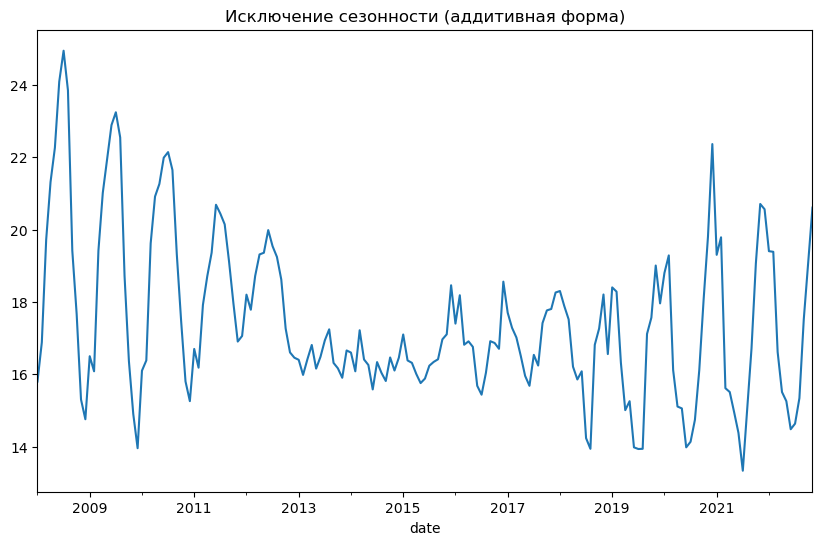

In [12]:
# Исключение сезонности
df_decompose_add["deseasonal"] = df_decompose_add["actual_values"] - df_decompose_add["seasonal"]
df_decompose_add["deseasonal"].plot()
plt.title("Исключение сезонности (аддитивная форма)")
plt.show()

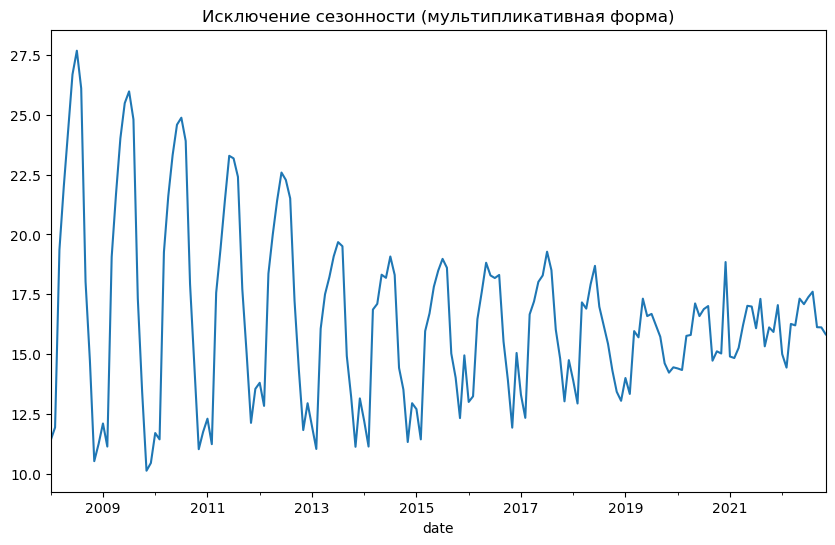

In [13]:
df_decompose_mult["deseasonal"] = df_decompose_mult["actual_values"] - df_decompose_mult["seasonal"]
df_decompose_mult["deseasonal"].plot()
plt.title("Исключение сезонности (мультипликативная форма)")
plt.show()

In [14]:
# Тест на наличие единичного корня по критерию Дики-Фуллера (аддитивная)
test_deseasonal_adfuller = adfuller(df_decompose_add['deseasonal'], autolag='AIC')
print(test_deseasonal_adfuller)

(-2.202482857466458, 0.20534555729881337, 14, 164, {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671}, 371.0563065389141)


In [15]:
print('test_adf: ', test_deseasonal_adfuller[0])
print('p-value: ', test_deseasonal_adfuller[1])
if test_deseasonal_adfuller[1] > 0.05:
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  -2.202482857466458
p-value:  0.20534555729881337
Есть единичный корень, ряд нестационарный


In [16]:
# Тест на наличие единичного корня по критерию Дики-Фуллера (мультипликативная)
test_deseasonal_adfuller = adfuller(df_decompose_mult['deseasonal'], autolag='AIC')
print(test_deseasonal_adfuller)

(-1.9511289431934158, 0.30840354911384193, 13, 165, {'1%': -3.470616369591229, '5%': -2.8792214018977655, '10%': -2.57619681359045}, 373.01570174904276)


In [17]:
print('test_adf: ', test_deseasonal_adfuller[0])
print('p-value: ', test_deseasonal_adfuller[1])
if test_deseasonal_adfuller[1] > 0.05:
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  -1.9511289431934158
p-value:  0.30840354911384193
Есть единичный корень, ряд нестационарный


**Вывод: временной ряд является нестационарным**

## 7. Построить стационарный ряд, используя оператор последовательных разностей (дифференцирование ряда).

**Тестирвоание ряда первых разностей**
$$\Delta T_{t} = T_{t} - T_{t-1}$$

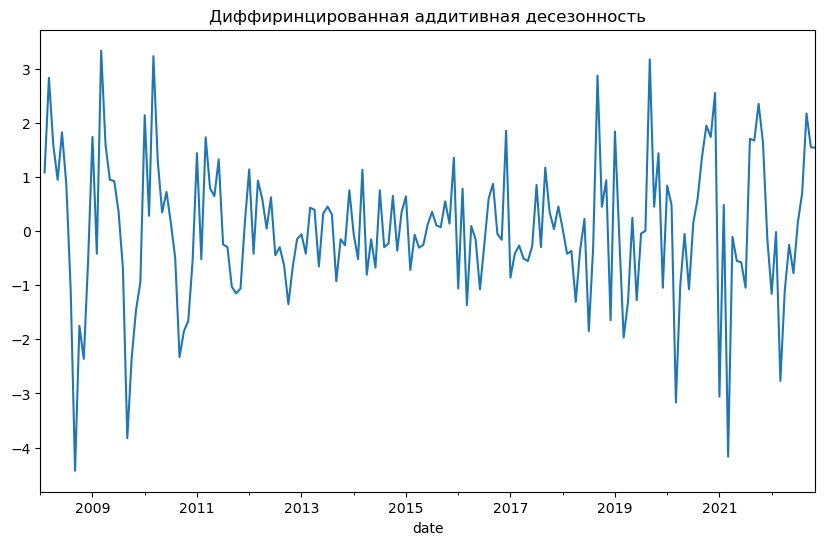

In [18]:
# Аддитивная модель
df_decompose_add['deseasonal_diff'] = df_decompose_add['deseasonal'].diff()
df_decompose_add['deseasonal_diff'].plot()
plt.title("Диффиринцированная аддитивная десезонность")
plt.show()

In [19]:
# Тест на наличие единичного корня по критерию Дики-Фуллера
test_deseasonal_diff_adfuller = adfuller(df_decompose_add['deseasonal_diff'][1:], autolag="AIC")
print('test_adf: ', test_deseasonal_diff_adfuller[0])
print('p-value: ', test_deseasonal_diff_adfuller[1])
if test_deseasonal_diff_adfuller[1] > 0.05:
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  -4.59083728379068
p-value:  0.00013428695412948542
Единичного корня нет, ряд стационарный


In [20]:
# Тест Филлипа-Перрона
pp = PhillipsPerron(df_decompose_add['deseasonal_diff'][1:])
print('test_pp: ', pp.stat)
print('p-value: ', pp.pvalue)
if pp.pvalue > 0.05:
    print('Ряд нестационарный')
else:
    print('Ряд стационарный')

test_pp:  -9.979863321471218
p-value:  2.128838865075823e-17
Ряд стационарный


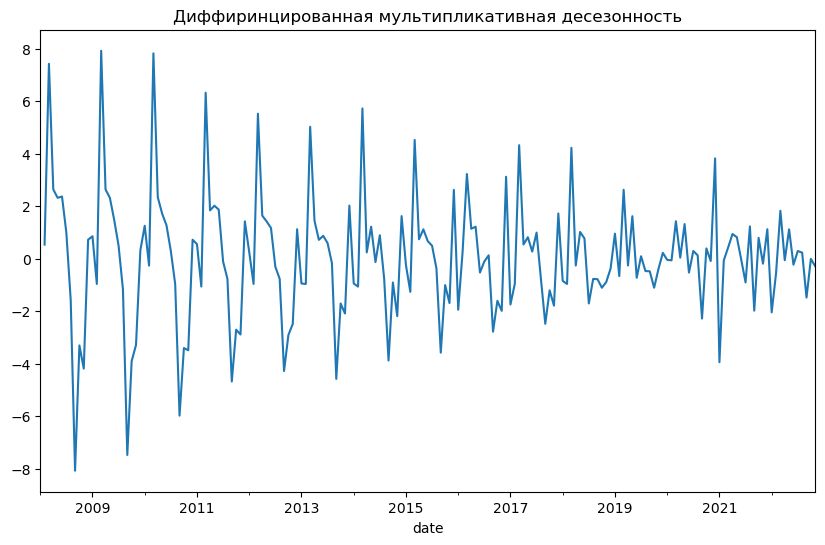

In [21]:
# Мультипликативная модель
df_decompose_mult['deseasonal_diff'] = df_decompose_mult['deseasonal'].diff()
df_decompose_mult['deseasonal_diff'].plot()
plt.title("Диффиринцированная мультипликативная десезонность")
plt.show()

In [22]:
# Тест на наличие единичного корня по критерию Дики-Фуллера
test_deseasonal_diff_adfuller = adfuller(df_decompose_mult['deseasonal_diff'][1:], autolag="AIC")
print('test_adf: ', test_deseasonal_diff_adfuller[0])
print('p-value: ', test_deseasonal_diff_adfuller[1])
if test_deseasonal_diff_adfuller[1] > 0.05:
    print('Есть единичный корень, ряд нестационарный')
else:
    print('Единичного корня нет, ряд стационарный')

test_adf:  -3.254425988660664
p-value:  0.0170426681078791
Единичного корня нет, ряд стационарный


In [23]:
# Тест Филлипа-Перрона
pp = PhillipsPerron(df_decompose_mult['deseasonal_diff'][1:])
print('test_pp: ', pp.stat)
print('p-value: ', pp.pvalue)
if pp.pvalue > 0.05:
    print('Ряд нестационарный')
else:
    print('Ряд стационарный')

test_pp:  -10.773525994837716
p-value:  2.351177556764856e-19
Ряд стационарный


## 8. Построить ARIMA-модель, обосновать параметры выбора модели.

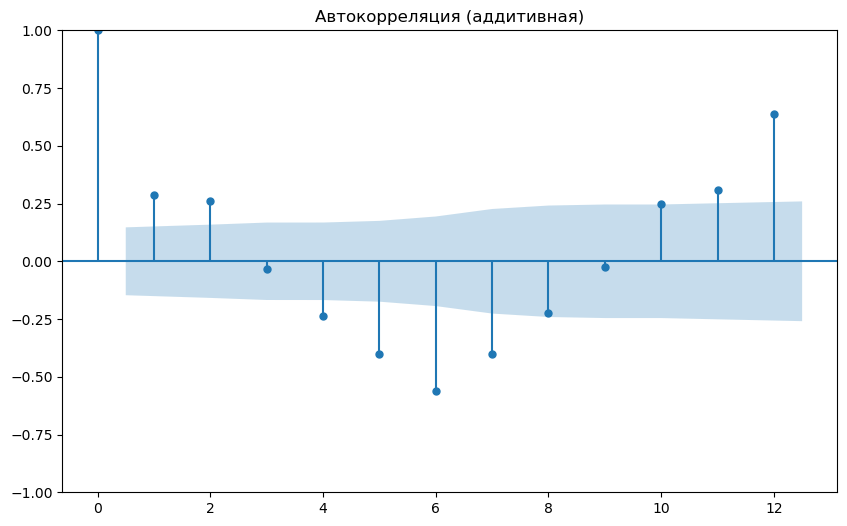

In [24]:
plot_acf(df_decompose_add["deseasonal_diff"][1:], lags=12)
plt.title("Автокорреляция (аддитивная)")
plt.show()

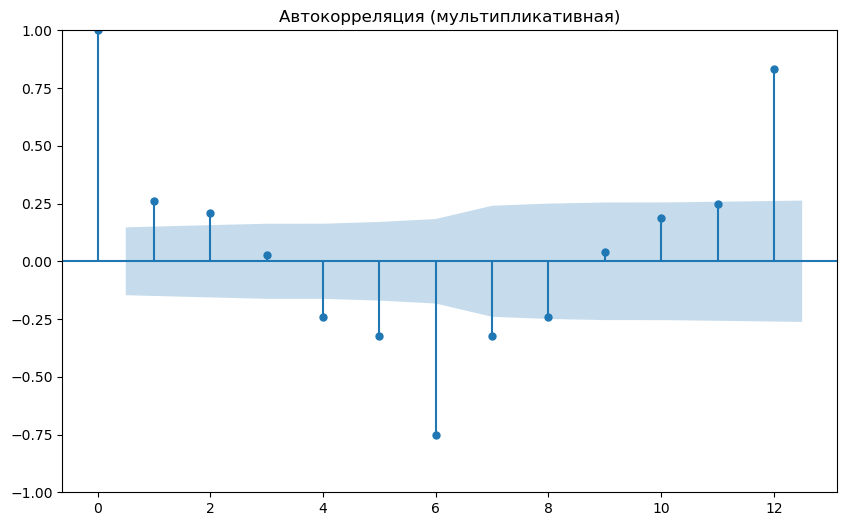

In [25]:
plot_acf(df_decompose_mult["deseasonal_diff"][1:], lags=12)
plt.title("Автокорреляция (мультипликативная)")
plt.show()

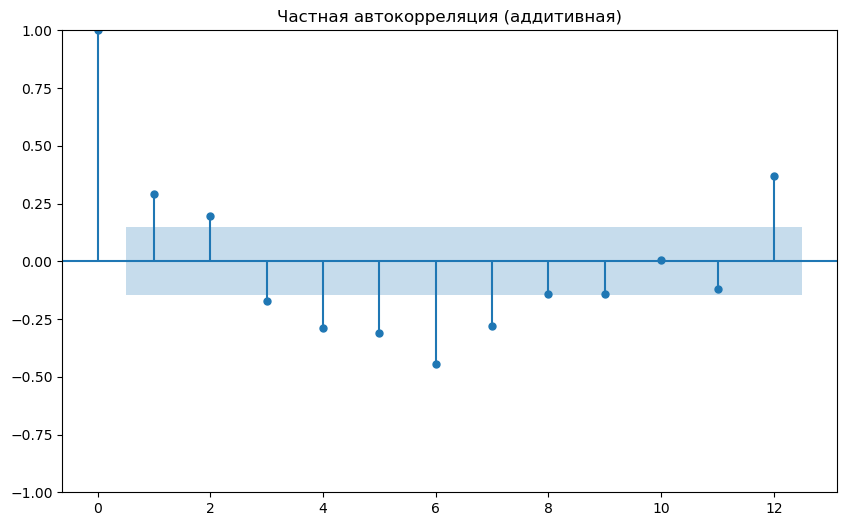

In [26]:
plot_pacf(df_decompose_add['deseasonal_diff'][1:], lags=12)
plt.title("Частная автокорреляция (аддитивная)")
plt.show()

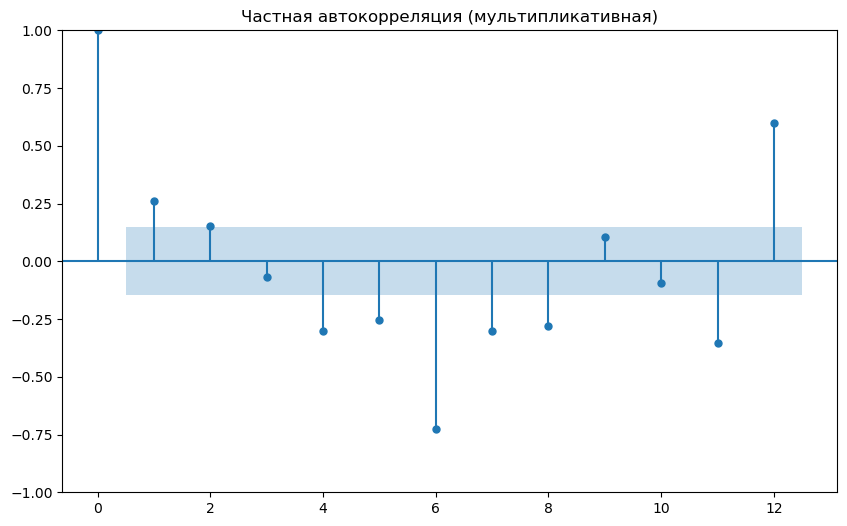

In [27]:
plot_pacf(df_decompose_mult['deseasonal_diff'][1:], lags=12)
plt.title("Частная автокорреляция (мультипликативная)")
plt.show()

In [28]:
# Инициализация и обучение модели (для аддитивной декомпозиции)
model_ARIMA_add = ARIMA(df_decompose_add.deseasonal, order=(2, 1, 0))
results_ARIMA_add = model_ARIMA_add.fit()
results_ARIMA_add.fittedvalues.head()

date
2008-01-01     0.000000
2008-02-01    15.802493
2008-03-01    17.203352
2008-04-01    20.601663
2008-05-01    22.266453
dtype: float64

In [29]:
# Вывод информации о модели
results_ARIMA_add.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             deseasonal   No. Observations:                  179
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -285.879
Date:                Fri, 13 Jan 2023   AIC                            577.759
Time:                        11:06:35   BIC                            587.304
Sample:                    01-01-2008   HQIC                           581.630
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2331      0.081      2.861      0.004       0.073       0.393
ar.L2          0.2056      0.066      3.121      0.002       0.076       0.335
sigma2         1.4525      0.109     13.374      0.000       1.240       1.665
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                41.16
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.47
Prob(H) (two-sided):                  0.48   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Вывод по summary:**

* Коэффициенты авторегрессии статистически значимы

* 0 не попадает в доверительные интервалы

**Итого: можно предположить что модель адекватна**

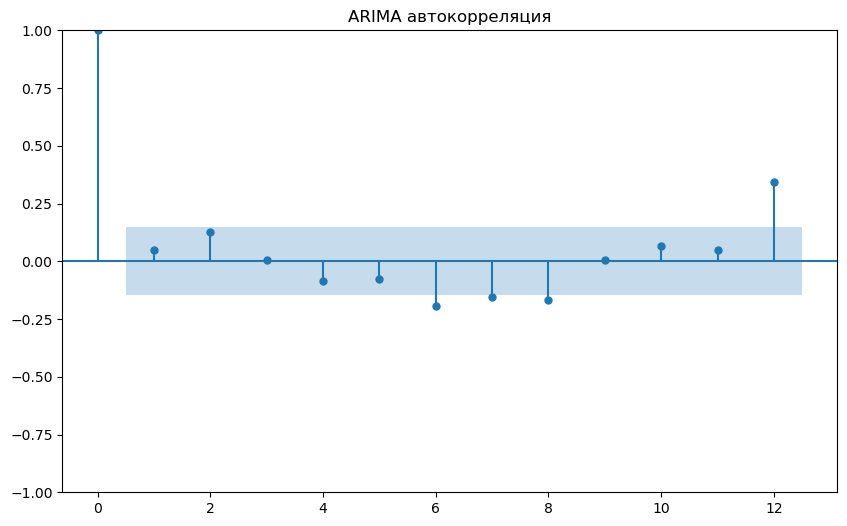

In [30]:
plot_pacf(results_ARIMA_add.resid, lags=12)
plt.title("ARIMA автокорреляция")
plt.show()

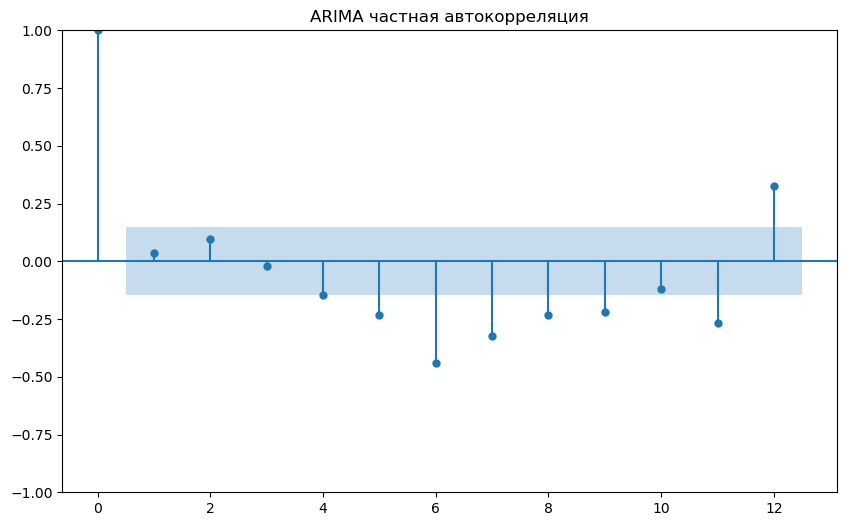

In [31]:
plot_pacf(results_ARIMA_add.resid[1:], lags=12)
plt.title("ARIMA частная автокорреляция")
plt.show()

**Вывод по аддитивной модели:**

* Исходя их автокорреляционных функций можно сделать вывод что модель адекватна, так как мы избавились от автокорреляции

**Итог: модель адекватна**

In [32]:
# Инициализация и обучение модели (для мультипликативной декомпозиции)
model_ARIMA_mult = ARIMA(df_decompose_mult.deseasonal, order=(1, 1, 0))
results_ARIMA_mult = model_ARIMA_mult.fit()
results_ARIMA_mult.fittedvalues.head()

date
2008-01-01     0.000000
2008-02-01    11.399970
2008-03-01    12.073790
2008-04-01    21.286522
2008-05-01    22.684476
dtype: float64

In [33]:
# Вывод информации о модели
results_ARIMA_mult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             deseasonal   No. Observations:                  179
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -398.922
Date:                Fri, 13 Jan 2023   AIC                            801.845
Time:                        11:06:35   BIC                            808.208
Sample:                    01-01-2008   HQIC                           804.425
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2593      0.101      2.563      0.010       0.061       0.458
sigma2         5.1758      0.349     14.813      0.000       4.491       5.861
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                72.02
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Вывод по summary:**

* Коэффициент авторегрессии статистически значим

**Итого: можно предположить что модель адекватна**

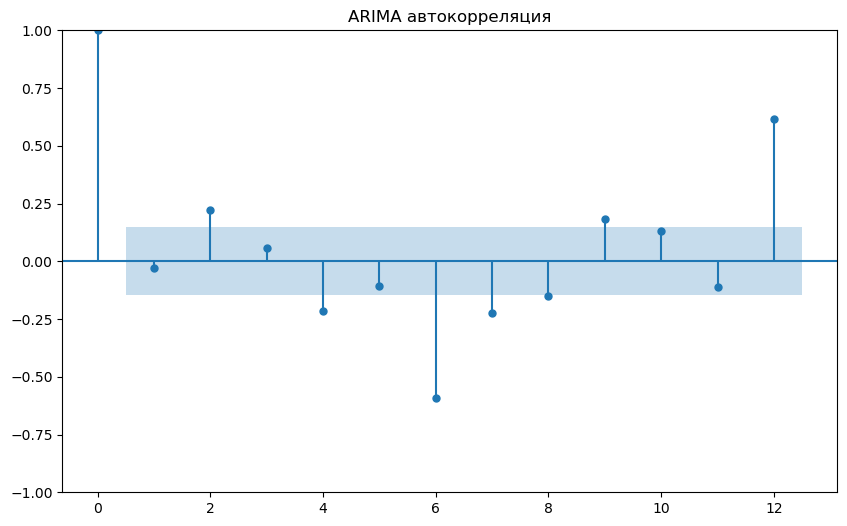

In [34]:
plot_pacf(results_ARIMA_mult.resid, lags=12)
plt.title("ARIMA автокорреляция")
plt.show()

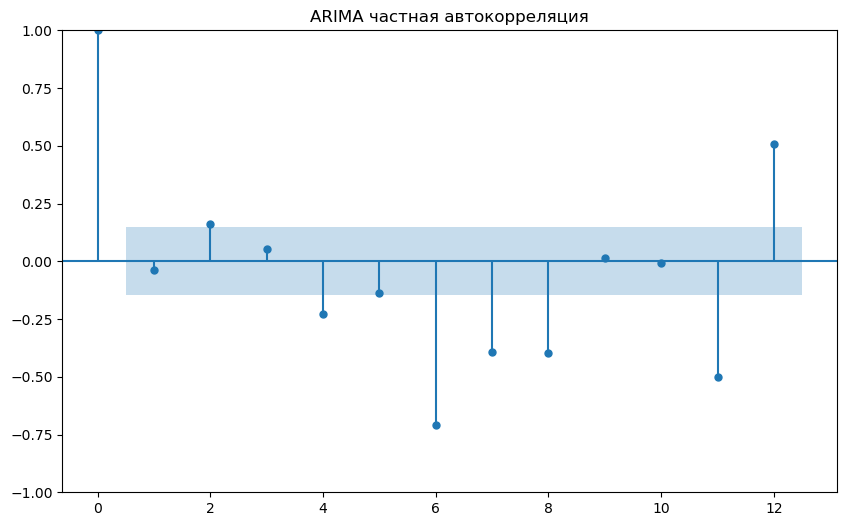

In [35]:
plot_pacf(results_ARIMA_mult.resid[1:], lags=12)
plt.title("ARIMA частная автокорреляция")
plt.show()

**Вывод по мультипликативной модели:**

* Исходя их автокорреляционных функций можно сделать вывод что модель адекватна, так как мы избавились от автокорреляции

**Итог: модель адекватна**

## 9. Провести графический анализ фактических, модельных значений, анализ остатков модели.

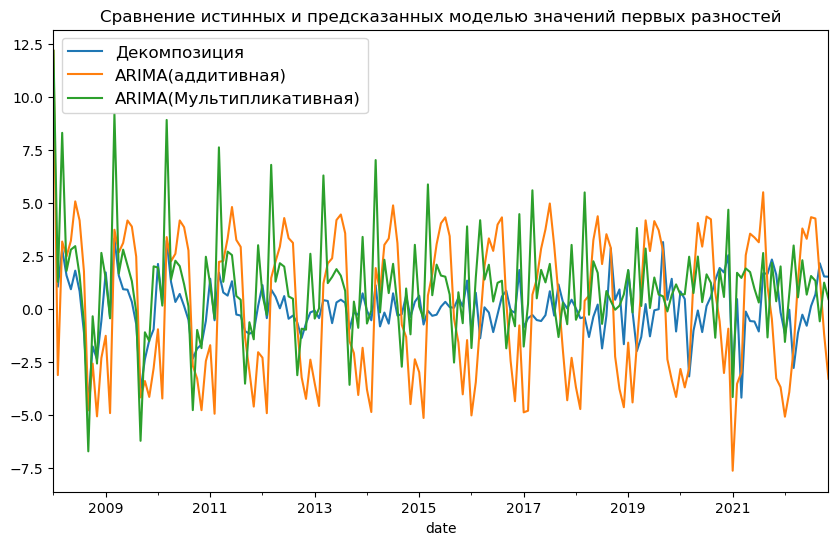

In [36]:
df_decompose_add["deseasonal_diff"].plot(label="Декомпозиция")
(df["milk"] - results_ARIMA_add.fittedvalues).plot(label="ARIMA(аддитивная)")
(df["milk"] - results_ARIMA_mult.fittedvalues).plot(label="ARIMA(Мультипликативная)")
plt.legend(title='', loc='upper left', fontsize=12)
plt.title("Сравнение истинных и предсказанных моделью значений первых разностей")
plt.show()

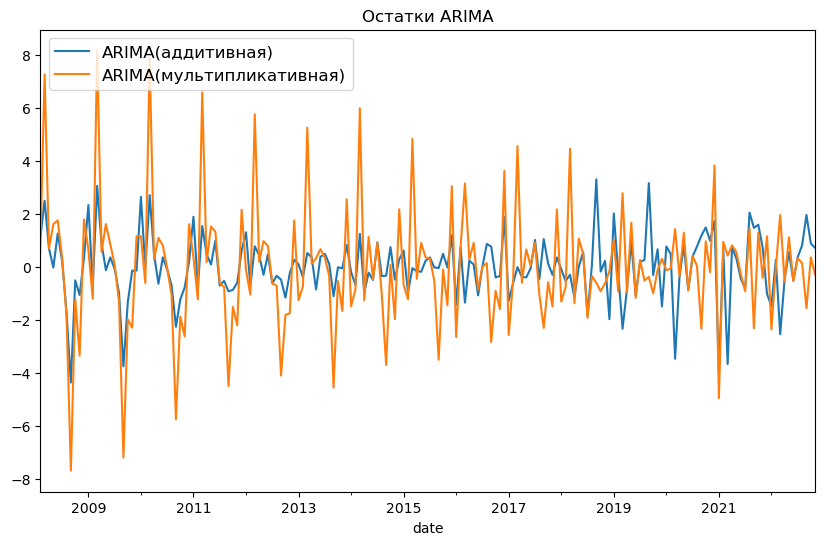

In [37]:
results_ARIMA_add.resid[1:].plot(label="ARIMA(аддитивная)")
results_ARIMA_mult.resid[1:].plot(label="ARIMA(мультипликативная)")
plt.legend(title='', loc='upper left', fontsize=12)
plt.title("Остатки ARIMA")
plt.show()

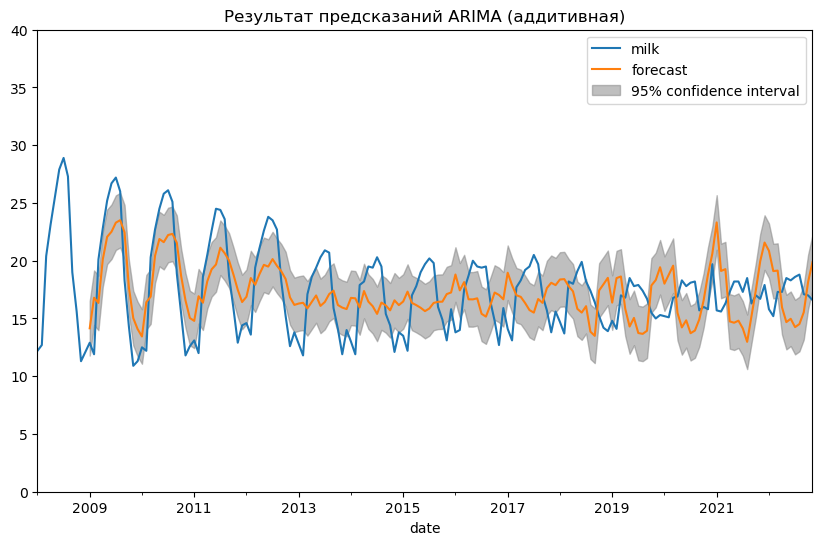

In [38]:
fig, ax = plt.subplots()
ax = plt.gca()
ax.set_ylim([0, 40])
ax = df.plot(ax=ax)
plot_predict(results_ARIMA_add, '2009', '2022', ax=ax)
plt.title("Результат предсказаний ARIMA (аддитивная)")
plt.show()

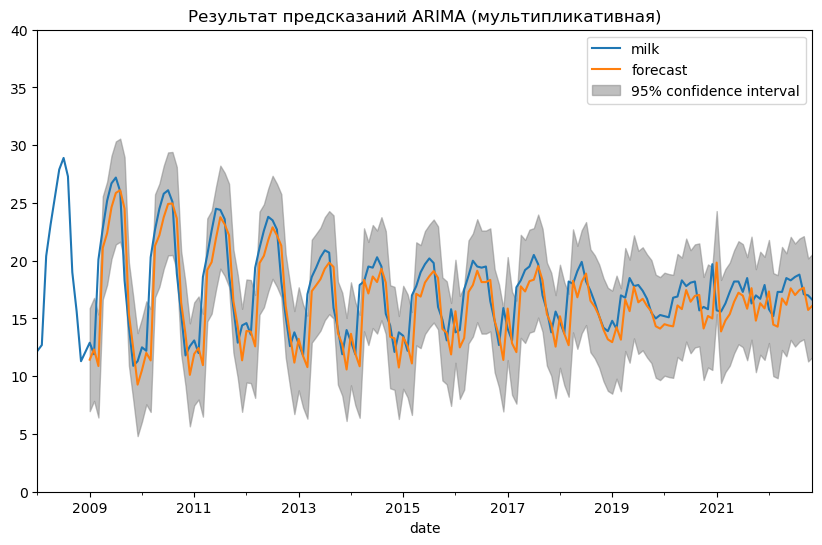

In [39]:
fig, ax = plt.subplots()
ax = plt.gca()
ax.set_ylim([0, 40])
ax = df.plot(ax=ax)
plot_predict(results_ARIMA_mult, '2009', '2022', ax=ax)
plt.title("Результат предсказаний ARIMA (мультипликативная)")
plt.show()

In [40]:
# Функции подбора параметров для ARIMA
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [41]:
p_values = range(3)
d_values = range(3)
q_values = range(3)
# evaluate_models(df_decompose_add.deseasonal, p_values, d_values, q_values)

## 10. Построить прогнозы.

In [42]:
print("Аддитивная")
print(f'Значение сезонной компоненты для декабря -- {df_decompose_add.seasonal.iloc[11]:.2f}')
print(f'Значение сезонной компоненты для января -- {df_decompose_add.seasonal.iloc[0]:.2f}')
print(f'Значение сезонной компоненты для февраля -- {df_decompose_add.seasonal.iloc[1]:.2f}')
print("-" * 20)
print("Мультипликативная")
print(f'Значение сезонной компоненты для декабря -- {df_decompose_mult.seasonal.iloc[11]:.2f}')
print(f'Значение сезонной компоненты для января -- {df_decompose_mult.seasonal.iloc[0]:.2f}')
print(f'Значение сезонной компоненты для февраля -- {df_decompose_mult.seasonal.iloc[1]:.2f}')

Аддитивная
Значение сезонной компоненты для декабря -- -2.66
Значение сезонной компоненты для января -- -3.60
Значение сезонной компоненты для февраля -- -4.19
--------------------
Мультипликативная
Значение сезонной компоненты для декабря -- 0.85
Значение сезонной компоненты для января -- 0.80
Значение сезонной компоненты для февраля -- 0.76


In [43]:
print("Аддитивная")
print(f'Прогнозное значение ряда на декабрь равно {results_ARIMA_add.forecast(steps=1)[0] + df_decompose_add.seasonal.iloc[11]:.2f}')
print(f'Прогнозное значение ряда на январь равно {results_ARIMA_add.forecast(steps=2)[0] + df_decompose_add.seasonal.iloc[0]:.2f}')
print(f'Прогнозное значение ряда на февраль равно {results_ARIMA_add.forecast(steps=3)[0] + df_decompose_add.seasonal.iloc[1]:.2f}')
print("-" * 20)
print("Мультипликативная")
print(f'Прогнозное значение ряда на декабрь равно {results_ARIMA_mult.forecast(steps=1)[0] * df_decompose_mult.seasonal.iloc[11]:.2f}')
print(f'Прогнозное значение ряда на январь равно {results_ARIMA_mult.forecast(steps=2)[0] * df_decompose_mult.seasonal.iloc[0]:.2f}')
print(f'Прогнозное значение ряда на февраль равно {results_ARIMA_mult.forecast(steps=3)[0] * df_decompose_mult.seasonal.iloc[1]:.2f}')

Аддитивная
Прогнозное значение ряда на декабрь равно 18.62
Прогнозное значение ряда на январь равно 17.68
Прогнозное значение ряда на февраль равно 17.10
--------------------
Мультипликативная
Прогнозное значение ряда на декабрь равно 13.44
Прогнозное значение ряда на январь равно 12.60
Прогнозное значение ряда на февраль равно 12.05


### Использование библиотеки sktime <a class="anchor" id="10.1"></a>

In [44]:
# Создаем датасет с предсказанными значениями
will = pd.DataFrame(index=pd.PeriodIndex(pd.date_range("2022-12", periods=3, freq="M")))
will["milk"] = [results_ARIMA_add.forecast(steps=1)[0] + df_decompose_add.seasonal.iloc[11], results_ARIMA_add.forecast(steps=2)[0] + df_decompose_add.seasonal.iloc[0], results_ARIMA_add.forecast(steps=3)[0] + df_decompose_add.seasonal.iloc[1]]
will

,milk
2022-12,18.622781
2023-01,17.681552
2023-02,17.098491


In [45]:
# Функция вывода спрогнозированных данных и метрик модели
def metric_forecaster(forecaster, test):
    y_pred = forecaster.predict(fh=test.index)
    plot_series(y_pred, test, labels=["Спрогнозированное", "Действительное"])
    plt.show()
    print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_pred, test):0.2f}")
    print(f"Среднеквадратичная геометрическая ошибка (GMSE): {geometric_mean_squared_error(y_pred, test):0.2f}")

#### Вариант с делением на обучающую и тестовую выборки

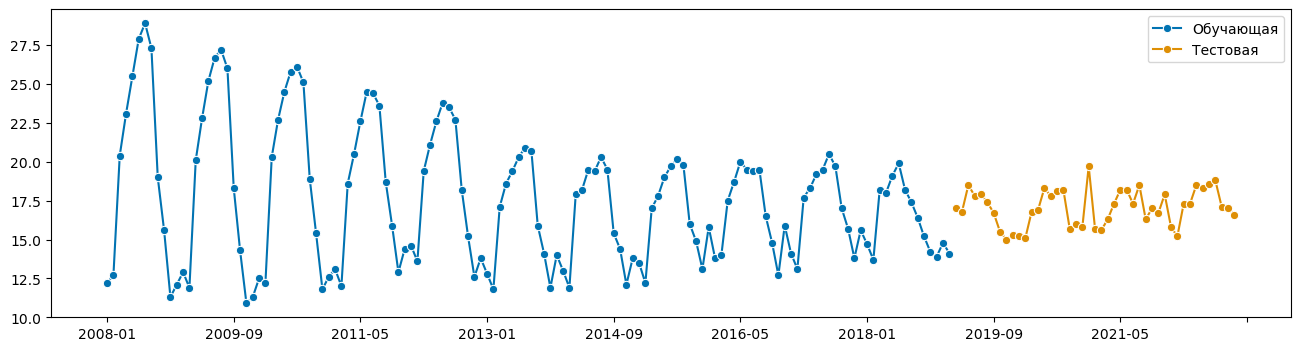

In [46]:
# Подготоваливаем обучающую и тестовую выборки
y = df["milk"]
y_sktime = y.reset_index()
y_sktime["date"] = pd.to_datetime(y.reset_index()["date"], errors='coerce').dt.to_period('m')
y_sktime = y_sktime.set_index("date")

y_train, y_test = temporal_train_test_split(y_sktime)
plot_series(y_train, y_test, labels=["Обучающая", "Тестовая"])
plt.show()

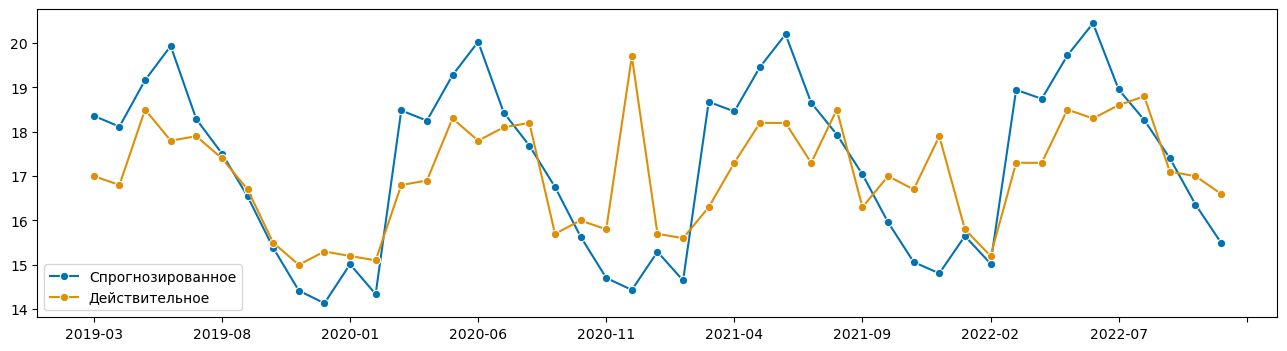

Среднеквадратичная ошибка (MSE): 2.11
Среднеквадратичная геометрическая ошибка (GMSE): 0.62


In [47]:
# SARIMAX
forecaster = SARIMAX(order=(1, 1, 1), trend="t", seasonal_order=(1, 0, 0, 12))
forecaster.fit(y_train)

metric_forecaster(forecaster, y_test)

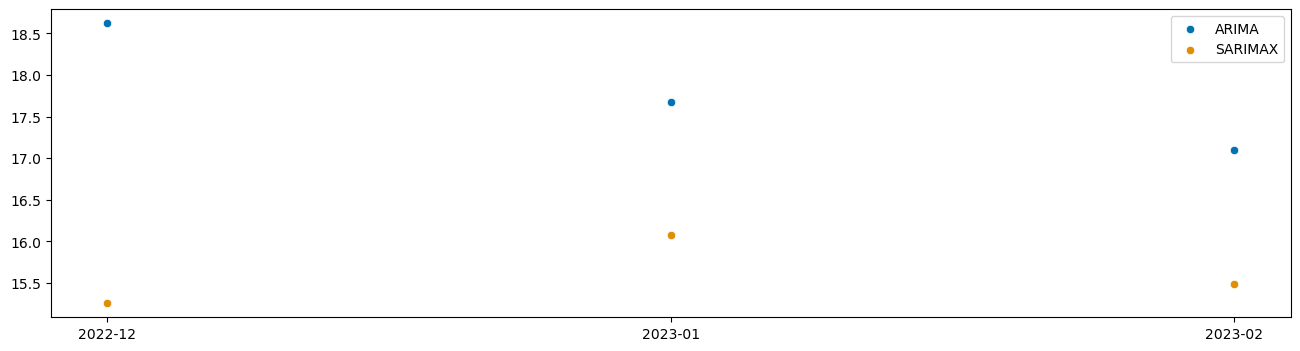

In [48]:
# Сравнение предсказаний ARIMA и SARIMAX будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "SARIMAX"])
plt.show()

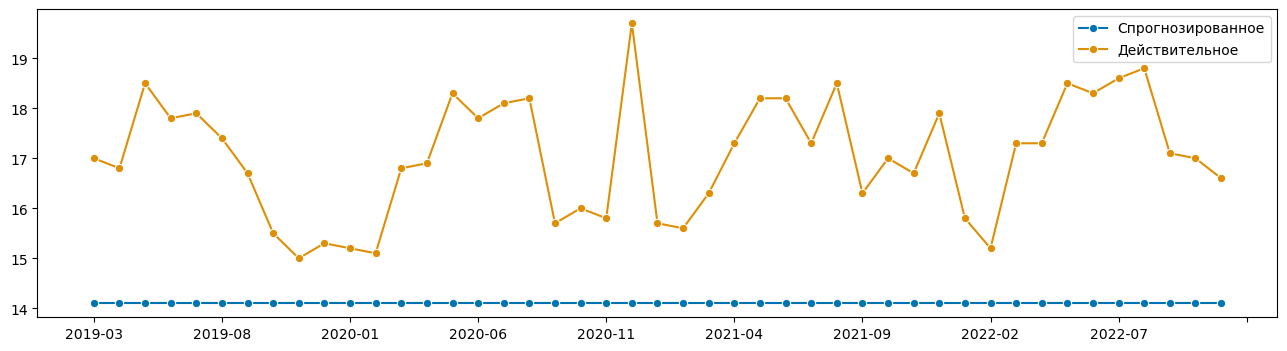

Среднеквадратичная ошибка (MSE): 10.05
Среднеквадратичная геометрическая ошибка (GMSE): 7.13


In [49]:
forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(y_train)

metric_forecaster(forecaster, y_test)

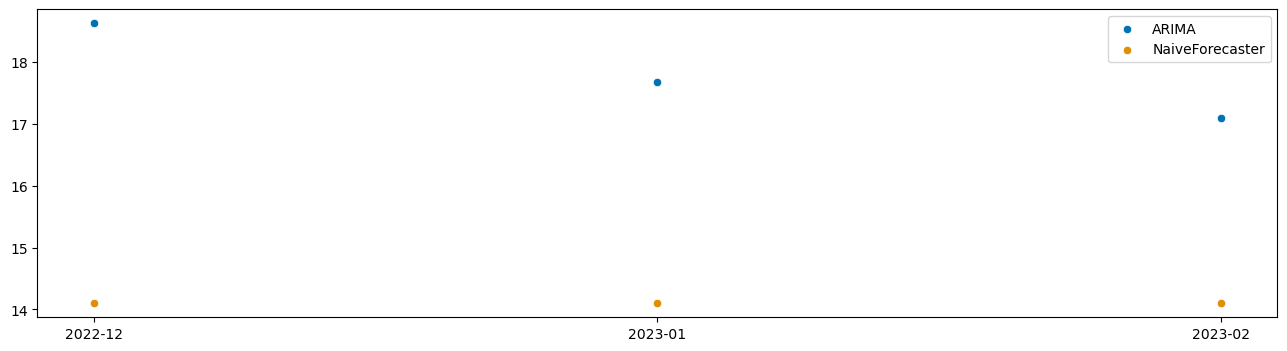

In [50]:
# Сравнение предсказаний ARIMA и NaiveForecaster будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "NaiveForecaster"])
plt.show()

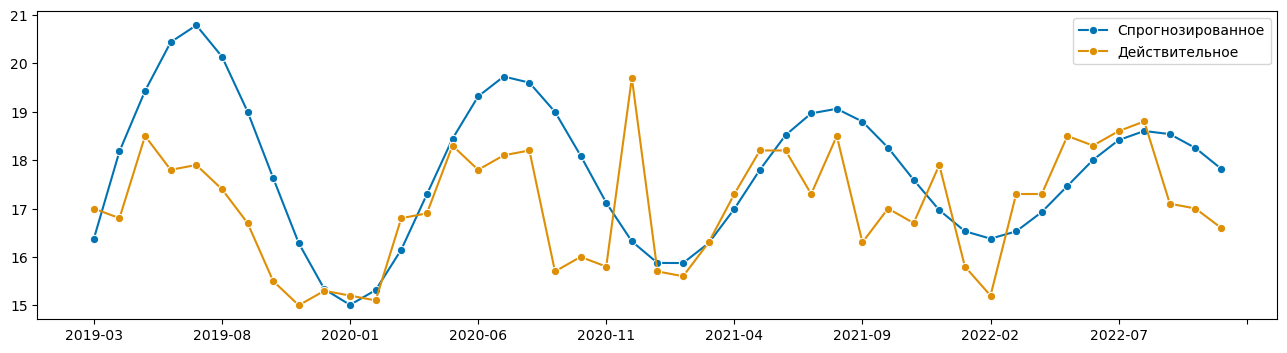

Среднеквадратичная ошибка (MSE): 2.12
Среднеквадратичная геометрическая ошибка (GMSE): 0.51


In [51]:
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
forecaster.fit(y_train)
metric_forecaster(forecaster, y_test)

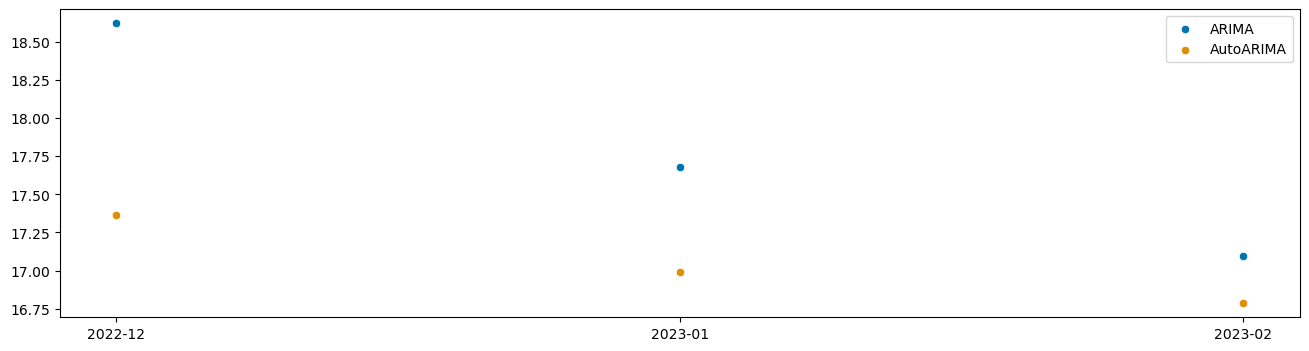

In [52]:
# Сравнение предсказаний ARIMA и AutoARIMA будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "AutoARIMA"])
plt.show()

#### Вариант с обучением на всей выборке

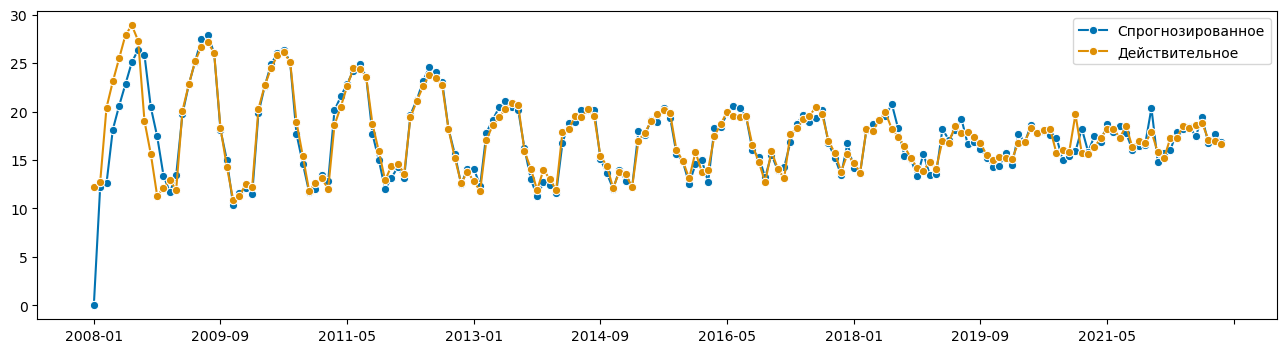

Среднеквадратичная ошибка (MSE): 2.93
Среднеквадратичная геометрическая ошибка (GMSE): 0.23


In [53]:
# SARIMAX
forecaster = SARIMAX(order=(1, 1, 1), trend="t", seasonal_order=(1, 0, 0, 12))
forecaster.fit(y_sktime)

metric_forecaster(forecaster, y_sktime)

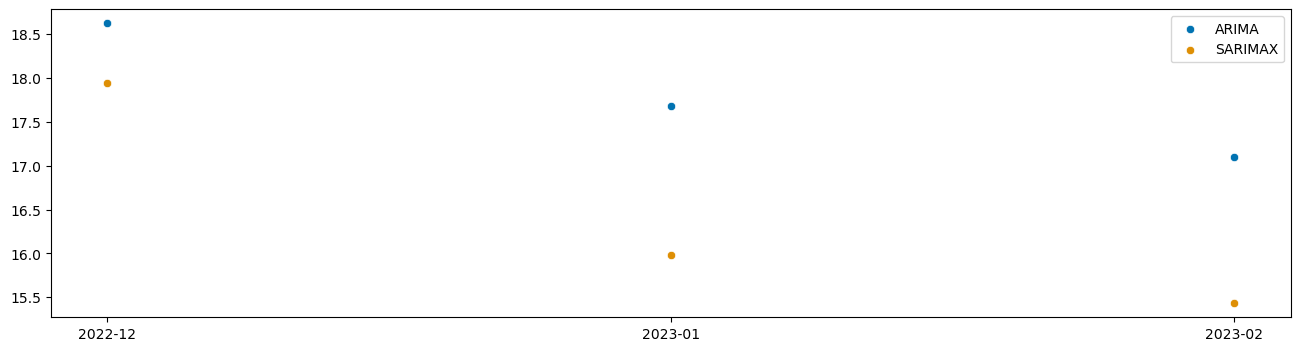

In [54]:
# Сравнение предсказаний ARIMA и SARIMAX будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "SARIMAX"])
plt.show()

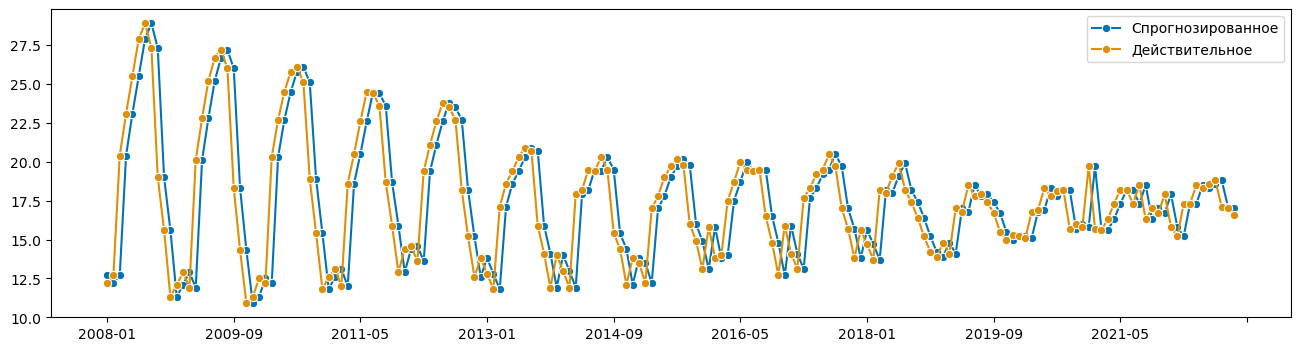

Среднеквадратичная ошибка (MSE): 6.00
Среднеквадратичная геометрическая ошибка (GMSE): 0.51


In [55]:
forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(y_sktime)

metric_forecaster(forecaster, y_sktime)

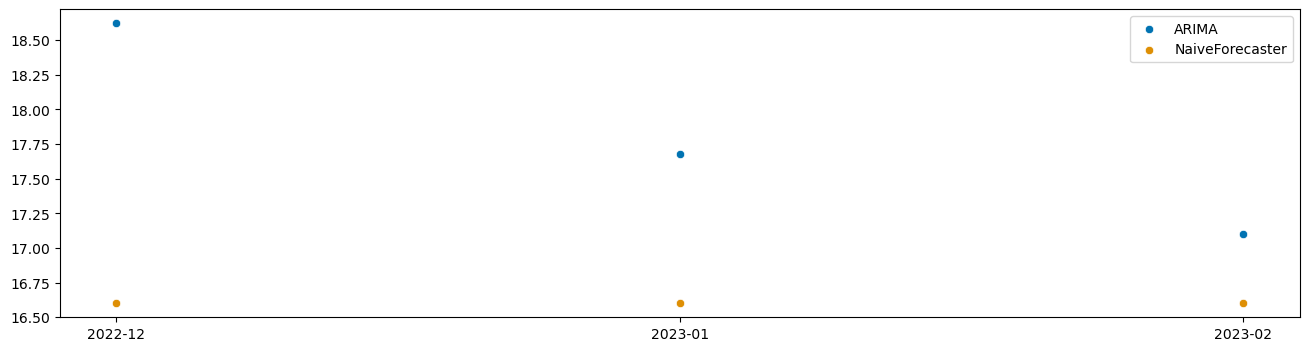

In [56]:
# Сравнение предсказаний ARIMA и NaiveForecaster будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "NaiveForecaster"])
plt.show()

In [57]:
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
forecaster.fit(y_sktime)
# AutoARIMA может предсказать только будующие значения, которых не было при обучении

AutoARIMA(suppress_warnings=True)

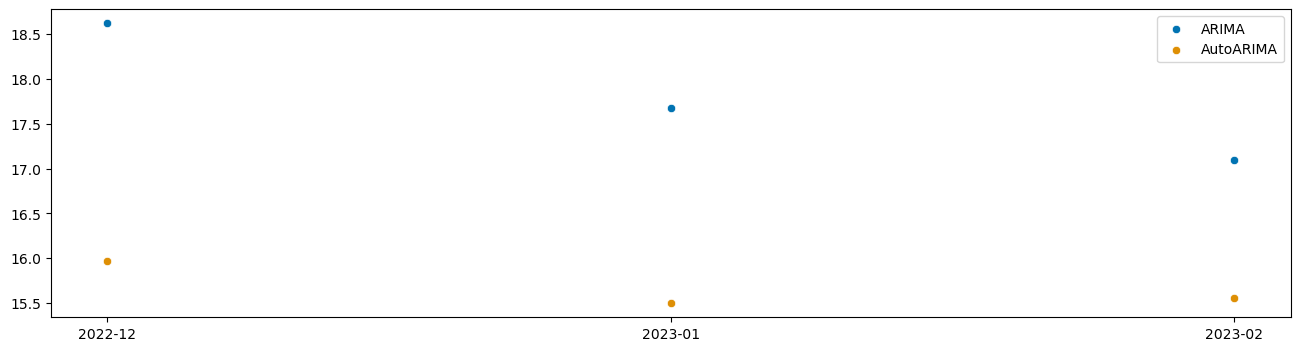

In [58]:
# Сравнение предсказаний ARIMA и AutoARIMA будующих 3 месяцев
y_pred = forecaster.predict(fh=will.index)
plot_series(will, y_pred, labels=["ARIMA", "AutoARIMA"])
plt.show()